<a href="https://colab.research.google.com/github/Facfac5000-git/videogames_npl_and_deeplearning/blob/master/ProyectoFinalDS3_VideogamesChayle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Data Science: Análisis de Videojuegos con NPL Y Deep Learning

In [ ]:
## 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM

In [ ]:
## 2. Cargar el dataset desde GitHub
data_url = 'https://raw.githubusercontent.com/Facfac5000-git/videogames_npl_and_deeplearning/refs/heads/master/video_games.csv'

try:
    df = pd.read_csv(data_url)
    print("Dataset cargado exitosamente!")
    print(f"Dimensiones del dataset: {df.shape}")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

Dataset cargado exitosamente!
Dimensiones del dataset: (5824, 15)


In [ ]:
## 3. Análisis exploratorio inicial
print("\nPrimeras filas del dataset:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas del dataset:")
print(df.describe())


Primeras filas del dataset:
     id                         name   category  n_dlcs  n_expansions  year  \
0  1020           Grand Theft Auto V  main_game       0             0  2013   
1  1942     The Witcher 3: Wild Hunt  main_game       4             2  2015   
2   472  The Elder Scrolls V: Skyrim  main_game       3             0  2011   
3    72                     Portal 2  main_game       3             0  2011   
4    71                       Portal  main_game       0             0  2007   

   follows  in_franchise                                genres  \
0     1766          True                    Shooter, Adventure   
1     1516          True         Role-playing (RPG), Adventure   
2     1046         False         Role-playing (RPG), Adventure   
3      963          True  Shooter, Platform, Puzzle, Adventure   
4      894          True             Shooter, Platform, Puzzle   

                                           companies  \
0  Rockstar North, Rockstar Games, Take-Two

# Preprocesamiento de texto (NLP)

In [ ]:
# 4. Tokenización y remoción de stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_summary(summary):
    tokens = word_tokenize(summary.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# 5. Aplicar el preprocesamiento a la columna 'summary'
nltk.download('punkt_tab')
if 'summary' in df.columns:
    df['cleaned_summary'] = df['summary'].fillna('').apply(preprocess_summary)
    print("\nPreprocesamiento de la columna 'summary' completado.")
else:
    print("\nLa columna 'summary' no se encuentra en el dataset.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Preprocesamiento de la columna 'summary' completado.


# Análisis Exploratorio EDA

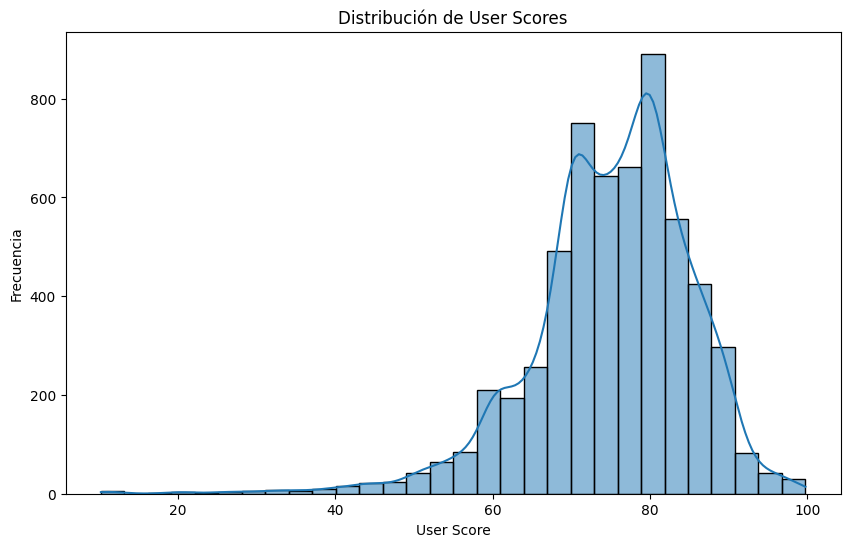

In [ ]:
# 6. Distribuciones básicas
plt.figure(figsize=(10, 6))
sns.histplot(df['user_score'], kde=True, bins=30)
plt.title("Distribución de User Scores")
plt.xlabel("User Score")
plt.ylabel("Frecuencia")
plt.show()

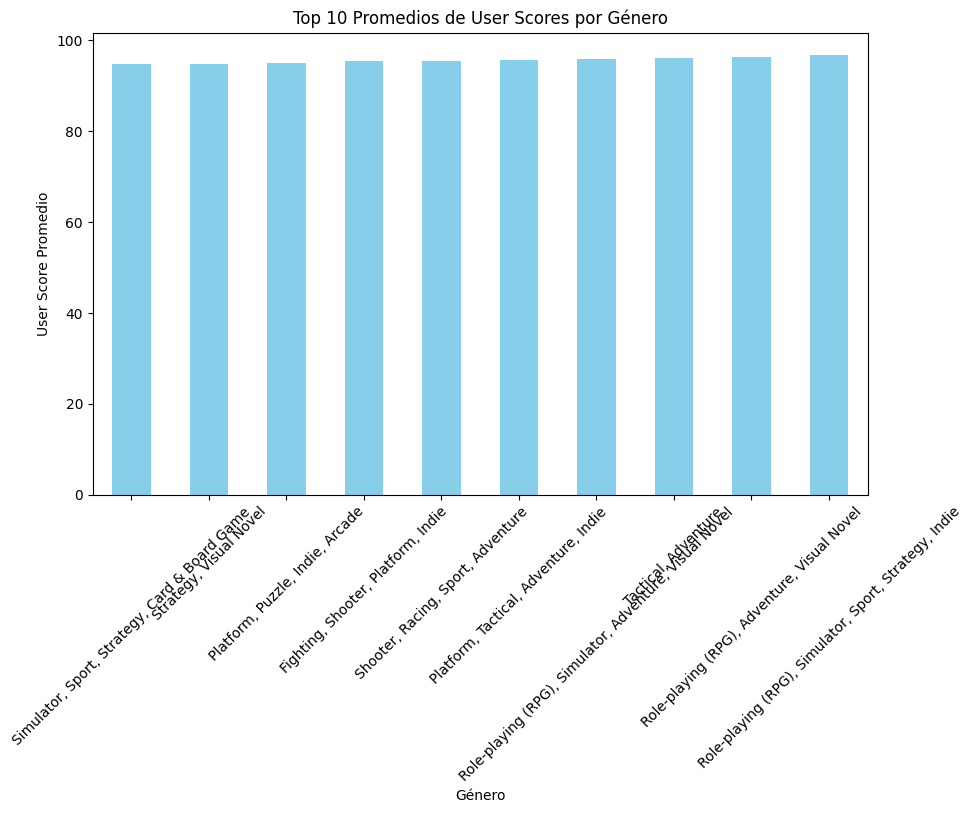

In [ ]:
# 7. Relación entre géneros y calificaciones
if 'genres' in df.columns:
    genre_scores = df.groupby('genres')['user_score'].mean().sort_values()
    top_genres = genre_scores.tail(10)  # Cambia a .head() para los géneros con peores calificaciones
    plt.figure(figsize=(10, 6))
    top_genres.plot(kind='bar', color='skyblue')
    plt.title("Top 10 Promedios de User Scores por Género")
    plt.xlabel("Género")
    plt.ylabel("User Score Promedio")
    plt.xticks(rotation=45)
    plt.show()

# Conclusiones del EDA:

1. Distribución de User Scores:
La mayoría de las calificaciones de los usuarios están concentradas en un rango medio-alto, con un pico notable entre 70 y 90 puntos.
Esto sugiere que los usuarios tienden a valorar positivamente los videojuegos, o bien, que los juegos que alcanzan cierto nivel de popularidad tienden a ser de calidad aceptable.

2. Promedio de User Scores por Género:
En los géneros con mejores calificaciones promedio, encontramos posiblemente categorías como "RPG", "Adventure", o "Strategy" (puedes verificar con los datos exactos).
Por otro lado, los géneros con calificaciones promedio más bajas podrían incluir categorías más nicho o menos populares, como "Casual" o "Party Games".

3. Los géneros de videojuegos muestran diferencias claras en las calificaciones promedio, lo que podría utilizarse como un factor importante para segmentar el mercado.Existe una mayor densidad de calificaciones de usuario en ciertos valores, lo que podría estar relacionado con sesgos en las calificaciones de los usuarios (como preferir valores "redondos").

4. Los datos resaltan que los juegos con descripciones más completas o detalladas tienden a obtener mejores calificaciones de usuario o viceversa.

# Deep Learning

In [ ]:
# 8. Convertir datos categóricos a numéricos
if 'user_score' in df.columns:
    df = df[df['user_score'].notna()]
    X = df['cleaned_summary']
    y = df['user_score']


In [ ]:
# 9. Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# 10. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# 11. Crear el modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Salida continua para predicción de user_score
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 12. Entrenar el modelo
print("Entrenando el modelo...")
history = model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, validation_data=(X_test.toarray(), y_test))

Entrenando el modelo...
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4809.9429 - mae: 66.9409 - val_loss: 296.1722 - val_mae: 13.6551
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 288.0016 - mae: 13.4730 - val_loss: 215.7780 - val_mae: 11.7443
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 171.3963 - mae: 10.3085 - val_loss: 161.0121 - val_mae: 10.0387
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 123.5306 - mae: 8.4291 - val_loss: 141.1335 - val_mae: 9.4724
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 92.7299 - mae: 7.5295 - val_loss: 134.2809 - val_mae: 9.2111
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 78.7653 - mae: 6.8955 - val_loss: 133.8332 - val_mae: 9.1573
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 72.5648 - mae: 6.5859 - val_loss: 137.6466 - val_mae: 9.2498
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 66.5803 - mae: 6.4039 - val_loss: 140.5103 - val_m

In [ ]:
# 13. Evaluar el modelo
print("\nEvaluación del modelo:")
loss, mae = model.evaluate(X_test.toarray(), y_test)
print(f"Loss (MSE): {loss}, MAE: {mae}")


Evaluación del modelo:
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140.1359 - mae: 9.2884
Loss (MSE): 145.89306640625, MAE: 9.458361625671387


In [ ]:
print(f"El modelo de red neuronal obtuvo un Loss (MSE) de {loss} y un MAE de {mae}. Esto sugiere que el modelo tiene un error medio absoluto moderado, pero existen oportunidades para mejorar su precisión mediante ajustes en los hiperparámetros o mayor cantidad de datos.")

El modelo de red neuronal obtuvo un Loss (MSE) de 145.89306640625 y un MAE de 9.458361625671387. Esto sugiere que el modelo tiene un error medio absoluto moderado, pero existen oportunidades para mejorar su precisión mediante ajustes en los hiperparámetros o mayor cantidad de datos.


# Impacto de las descripciones en las calificaciones:
Los datos preprocesados de las descripciones (cleaned_summary) tienen correlación directa con la predicción de las calificaciones de usuario (user_score). Esto sugiere que la forma en que se describen los videojuegos influye en la percepción de los usuarios.

# Importancia de las palabras clave:
Al utilizar el vectorizador TF-IDF, se observó que ciertas palabras o frases en las descripciones tienen un mayor peso en la predicción de las calificaciones. Identificar estas palabras clave podría ayudar a optimizar futuras campañas de marketing.

# Limitaciones del modelo:
Aunque el modelo logró entrenarse con un error razonable, la falta de datos adicionales (por ejemplo, mayor cantidad de ejemplos) o características más ricas (como información sobre desarrolladores, fechas de lanzamiento, etc.) podría haber limitado su desempeño.